# Imports

In [1]:
import os
import time
import datetime
import pickle
import random
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf

import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l1, l2
from keras.metrics import mean_squared_error

# fix random seed for reproducability
def fix_random(seed):
    os.environ['PYTONHASHSEED'] = '0'
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
fix_random(seed=0)
RANDOM_STATE = 1

# Read data
- read csv files
- shuffle
- separate X, y


In [2]:
def read_csvs(csv_files, verbose=True):
    '''Read a list of csv files into a single ndarray'''
    m = np.array([])
    for csv in csv_files:
        if verbose:
            print('loading:', csv)
        a = np.genfromtxt(csv, delimiter=',', dtype=int)
        if (0 == m.shape[0]):
            m = a
        else:
            np.append(m, a, axis=0)
    return m

# read csv files
csv_files = [os.path.join('data', f) for f in os.listdir('data')]

# read first file only: df = read_csvs([csv_files[0]], verbose=False)
M = read_csvs(csv_files, verbose=True)

# suffle
np.random.shuffle(M)

# separate X from y
y = M[:, 0]
X = M[:, 1:]

print('X.shape:', X.shape)
print('y.shape:', y.shape)


loading: data/yulesimon_alpha=2.01_loc=0_rows=1000_cols=10000.csv
loading: data/yulesimon_alpha=3.00_loc=0_rows=1000_cols=10000.csv
loading: data/yulesimon_alpha=2.50_loc=0_rows=1000_cols=10000.csv
X.shape: (1000, 10000)
y.shape: (1000,)


# Preprocess data

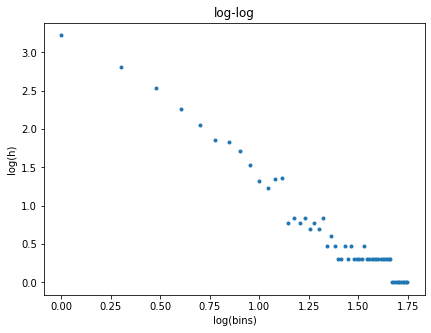

In [3]:
# convert each row of X to a histogram
nbins = np.max(X)
H = np.apply_along_axis(lambda a: np.histogram(a, bins=nbins, density=False)[0], 1, X)

# log scale H rows
logH = np.apply_along_axis(lambda a: np.log10(a+1), 1, H)
# log also number of bins
log_bins = np.log10(np.arange(nbins))

def drop_zeros(t):
    idx = np.argwhere(t > 0)
    rows,cols = np.max(idx, axis=0)
    res = np.zeros((rows+1,cols+1))

    ks = np.zeros(idx.shape[0], dtype=int)
    for i, j in idx:
        res[i, ks[i]] = t[i,j]
        ks[i] += 1
    return res

def drop_zero_columns(t):
    idx = np.where(t.any(axis=0))[0]
    return t[np.ix_(np.arange(t.shape[0]), idx)]

logHfixed = drop_zero_columns(drop_zeros(logH))
log_bins = np.log10(np.arange(logHfixed.shape[1]))

# plot
plt.figure(figsize=(15, 5))
ax2 = plt.subplot(1, 2, 2)
plt.gca().set(title='log-log', xlabel='log(bins)', ylabel='log(h)')
plt.scatter(log_bins, logHfixed[0], marker='.')
print()

## split train/validation/test

In [4]:
# train/test
X_train, X_test, y_train, y_test = train_test_split(logHfixed, y, test_size=0.2, random_state=RANDOM_STATE)

# train/val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=RANDOM_STATE)

print('X_train.shape: {}'.format(X_train.shape))
print('X_val.shape: {}'.format(X_val.shape))
print('X_test.shape: {}'.format(X_test.shape))


X_train.shape: (600, 57)
X_val.shape: (200, 57)
X_test.shape: (200, 57)


## Create Model

In [5]:
def create_model(n_features, 
                 layers, 
                 activation='relu', 
                 init='he_uniform', 
                 batch_normalization=False, 
                 dropout=0, 
                 optimizer='adam', 
                 k_reg=False, 
                 k_reg_lr=0.001, 
                 a_reg=False, 
                 a_reg_lr=0.001):

    model = Sequential()
    
    # ============
    # input-layer
    # ============
    model.add(Dense(units=layers[0]
                      , input_dim=n_features
                      , kernel_initializer=init
                      , activation=activation
                      # , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                      # , activity_regularizer=l2(a_reg_lr) if a_reg else None)
                    ))
    
    
    if batch_normalization:
        model.add(BatchNormalization())

    if dropout > 0:
        model.add(Dropout(dropout))

    # ==============
    # hidden-layers
    # ==============
    for units in layers[1:]:
        model.add(Dense(units=units
                        , kernel_initializer=init
                        , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                        , activity_regularizer=l2(a_reg_lr) if a_reg else None
                        ))

    if batch_normalization:
        model.add(BatchNormalization())

    model.add(Activation(activation))
    
    if dropout > 0:
        model.add(Dropout(dropout))

    # =============
    # output-layer
    # =============
    model.add(Dense(units=1
                    , activation='linear'
                    , kernel_initializer=init
                  # , kernel_regularizer=l2(k_reg_lr) if k_reg else None
                  # , activity_regularizer=l2(a_reg_lr) if a_reg else None)
                    ))
    
    # model.compile(loss='mse', metrics=['acc'], optimizer=optimizer)
    model.compile(loss='mse', metrics=['mse'], optimizer=optimizer)

    return model


## Training

In [6]:
BATCH_SIZE = 1024
MODEL_PREFIX = 'yulesimon'

def train(X_train, y_train):
    model = create_model(X_train.shape[1], 
                         #layers=[256, 256, 256], # acc=0.39
                         layers=[256, 256], # acc=0.44
                         #layers=[256, 128, 64], # acc=0.44
                         activation='relu', 
                         #init='he_uniform', 
                         init=keras.initializers.HeUniform(seed=RANDOM_STATE), 
                         batch_normalization=False, 
                         dropout=0, 
                         optimizer=Adam(lr=1e-3), 
                         k_reg=False, 
                         k_reg_lr=1e-5, 
                         a_reg=False, 
                         a_reg_lr=1e-6)
    
    # split train/validation
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)
    
    # early-stopping
    es_patience = 100
    es = EarlyStopping(monitor='val_loss', 
                        patience=es_patience, 
                        mode='min', 
                        restore_best_weights=True, 
                        verbose=1)
    
    # model checkpoint
    if not os.path.exists('models'):
        os.makedirs('models')
    date_str = datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
    model_path = 'models/{}_{}.h5'.format(MODEL_PREFIX, date_str)
    
    cp = ModelCheckpoint(filepath=model_path, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
    
    # reduce learning-rate on plateau
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=min(20, int(es_patience/2)))
    
    # fit model
    history = model.fit(X_train, 
                        y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=3000, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False, callbacks=[es, reduce_lr, cp], 
                        verbose=1)
    
    # history_unique_name = 'models/{}_{}.history'.format(MODEL_PREFIX, date_str)
    # with open(history_unique_name, 'wb') as f:
    #     pickle.dump(history, f)
    
    # load best weights from last checkpoint
    print('model path:', model_path)
    model = keras.models.load_model(model_path)
    return model, history

if True:
    model, history = train(X_train, y_train)

/1 [==============================] - ETA: 0s - loss: 3.0909e-04 - mse: 3.0909e-04
Epoch 00683: val_loss did not improve from 0.00047
1/1 [==============================] - 0s 15ms/step - loss: 3.0909e-04 - mse: 3.0909e-04 - val_loss: 4.7386e-04 - val_mse: 4.7386e-04
Epoch 684/3000
1/1 [==============================] - ETA: 0s - loss: 3.0909e-04 - mse: 3.0909e-04
Epoch 00684: val_loss did not improve from 0.00047
1/1 [==============================] - 0s 14ms/step - loss: 3.0909e-04 - mse: 3.0909e-04 - val_loss: 4.7386e-04 - val_mse: 4.7386e-04
Epoch 685/3000
1/1 [==============================] - ETA: 0s - loss: 3.0909e-04 - mse: 3.0909e-04
Epoch 00685: val_loss did not improve from 0.00047
1/1 [==============================] - 0s 16ms/step - loss: 3.0909e-04 - mse: 3.0909e-04 - val_loss: 4.7386e-04 - val_mse: 4.7386e-04
Epoch 686/3000
1/1 [==============================] - ETA: 0s - loss: 3.0909e-04 - mse: 3.0909e-04
Epoch 00686: val_loss did not improve from 0.00047
1/1 [=========

## Plot learning curves

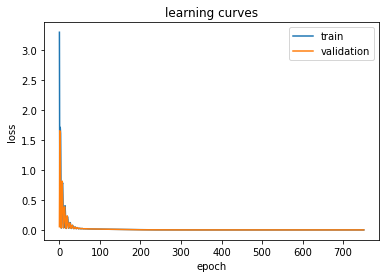

In [7]:
def plot_learning_curves(history, train_key='loss', val_key='val_loss'):
    plt.plot(history[train_key])
    plt.plot(history[val_key])
    plt.title('learning curves')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

if True:
    plot_learning_curves(history.history)

## Predict & test accuracy

In [8]:
y_pred = model.predict(X_test).flatten()
abs_residuals = np.abs(y_test - y_pred)
num_samples = abs_residuals.shape[0]

for max_abs_error in [0.01, 0.02, 0.03, 0.04, 0.05]:
    acc = np.sum((abs_residuals <= max_abs_error).astype(int), axis=0) / num_samples
    print()
    print('acc (max_abs_error = {}):'.format(max_abs_error), acc)
    print('average abs_residuals:', np.average(abs_residuals))


acc (max_abs_error = 0.01): 0.425
average abs_residuals: 0.015224167108535767

acc (max_abs_error = 0.02): 0.67
average abs_residuals: 0.015224167108535767

acc (max_abs_error = 0.03): 0.88
average abs_residuals: 0.015224167108535767

acc (max_abs_error = 0.04): 0.96
average abs_residuals: 0.015224167108535767

acc (max_abs_error = 0.05): 0.985
average abs_residuals: 0.015224167108535767
